# **Target Trial Emulation [Version 1]**

- Josef Hasm A. Agunod
- Sharly Pia Rose S. Barago

### **Introduction**  

Target Trial Emulation (TTE) is a method used to study treatment effects by making observational data look more like a real clinical trial. This helps reduce bias and get more accurate results.  

In this assignment, we’ll use Python to recreate TTE based on existing R code from [this tutorial](https://rpubs.com/alanyang0924/TTE). This first version (**TTE-v1**) focuses on:  

- Getting the dataset.  
- Converting the R code to Python.  
- Running the TTE steps and checking the results.  

This will prepare us for **TTE-v2**, where we’ll add clustering methods.  

# **Extracting the Dataset**

This step is all about preparing the data package for analysis. We got the data package from https://rpubs.com/alanyang0924/TTE by following the first few steps from Data Preparation.



# **Load and Prepare the Data in Python**

Here, we start converting the R code into Python for data manipulation. The block of code below is the equivalent Python Code from Alan Yang's R Code on Data Preparation.

In [ ]:
!pip install lifelines
import pandas as pd

# Load the dataset
data_censored = pd.read_csv("data_censored.csv")

# View first few rows
print(data_censored.head())

# Convert categorical variables (if needed)
data_censored['treatment'] = data_censored['treatment'].astype(int)
data_censored['outcome'] = data_censored['outcome'].astype(int)
data_censored['eligible'] = data_censored['eligible'].astype(int)

# Display dataset info
print(data_censored.info())


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null  

This gives us the same `head(data_censored)` output as in R.

---


# **Defining the Target Trial Data Structure**

We do this step by storing the trial sequence as a dictionary for later processing.

In [ ]:
# Define trial structure
trial_pp = {
    "data": data_censored,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Check the dataset summary
print(trial_pp["data"].describe())


               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.000000   -3.284355    0.000000   
25%     23.000000    2.000000    0.000000    0.000000   -0.809344    0.000000   
50%     50.000000    6.000000    0.000000    0.000000   -0.163060    0.000000   
75%     73.000000   12.000000    1.000000    1.000000    0.494103    1.000000   
max     99.000000   19.000000    1.000000    1.000000    3.907648    1.000000   

               x4         age       age_s     outcome   censored    eligible  
count  725.000000  725.000000  725.000000  725.000000  725.00000  725.000000  
mean    -0.274722   48.093793    1.091149    0.015172    0.08000    0.234483  
std      1.008643   11.834472    

For Intention-To-Treat (ITT) setup, we define:

In [ ]:
trial_itt = trial_pp.copy()  # Same dataset but different analysis

# **Inverse Probability of Censoring Weighting (IPCW)**

Rather than explaining what this is, we would like to explain what would happen without it:

Without IPCW, our survival analysis could be biased since it would only reflect patients who stayed in the study.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def calculate_ipcw_weights(data, censor_col, feature_cols):
    """
    Calculate inverse probability of censoring weights (IPCW).

    Parameters:
        - data: DataFrame containing the dataset.
        - censor_col: The column indicating if the observation was censored.
        - feature_cols: List of feature columns to predict censoring.

    Returns:
        - Updated DataFrame with computed IPCW weights.
    """
    # Prepare features (X) and target (y)
    X = data[feature_cols]
    y = 1 - data[censor_col]  # IPCW models censoring as (1 - censored)

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)

    # Predict probabilities (inverse of censoring probability)
    data["ipcw_weights"] = 1 / model.predict_proba(X)[:, 1]

    return data

# Apply IPCW model for censoring adjustments
feature_columns = ["x2", "x1"]  # Same features as in R example
data_censored = calculate_ipcw_weights(data_censored, "censored", feature_columns)

# Show the first few rows with weights
print(data_censored.head())


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  ipcw_weights  
0         0         1      1.096741  
1         0         0      1.057148  
2         0         0      1.086812  
3         0         0      1.108750  
4         0         0      1.063058  


# **Expanding Trials for Follow-ups**

This step simulates repeated follow-up periods by duplicating the dataset for each time point by adding a `trial_period` column. After expanding the dataset, we perform clustering to group similar observations.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def expand_trials(data, max_period=10):
    """
    Expands the dataset for each time period and applies clustering.
    """
    expanded_data = []

    for period in range(max_period):
        temp_data = data.copy()
        temp_data["trial_period"] = period
        expanded_data.append(temp_data)

    expanded_df = pd.concat(expanded_data, ignore_index=True)

    # Standardize features again after expansion
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_expanded = expanded_df[["x1", "x2", "age"]]  # Select relevant features
    X_scaled_expanded = scaler.fit_transform(X_expanded)

    # **Define clustering model INSIDE the function**
    num_clusters = 3  # Adjust based on silhouette score
    hc = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')

    # Apply clustering
    expanded_df["cluster"] = hc.fit_predict(X_scaled_expanded)

    return expanded_df

# Expand dataset and apply clustering
expanded_data = expand_trials(data_censored, max_period=10)


## **Hierarchical Clustering Visualization**

In this step, we visualize the cluster representations with a dendogram.

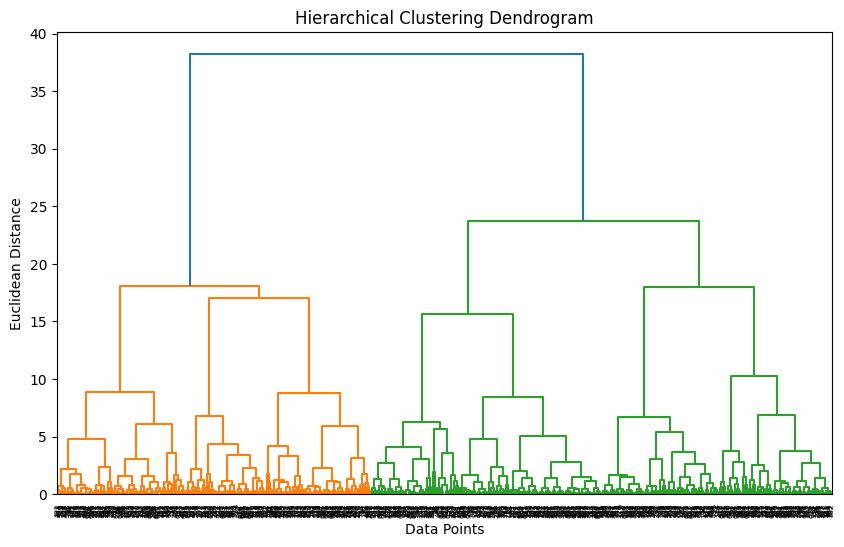

,count
cluster,
0,294
2,216
1,215


In [ ]:
# Now we perform hierarchical clustering on the dataset

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Select features for clustering
feature_cols = ["x1", "x2", "age"]  # Relevant features based on previous insights
X = data_censored[feature_cols]

# Standardize the features for better clustering performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform hierarchical clustering and plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

# Choose the number of clusters based on dendrogram (e.g., 3 clusters)
num_clusters = 3
hc = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
data_censored["cluster"] = hc.fit_predict(X_scaled)


# Check cluster distribution
cluster_counts = data_censored["cluster"].value_counts()
cluster_counts


## **Survival Analysis**

Here, we use Cox Proportional Hazards Model for our Survival Analysis. We use this because it flexibly estimates how variables affect the time until an event occurs in addition to it being able to handle censored data.

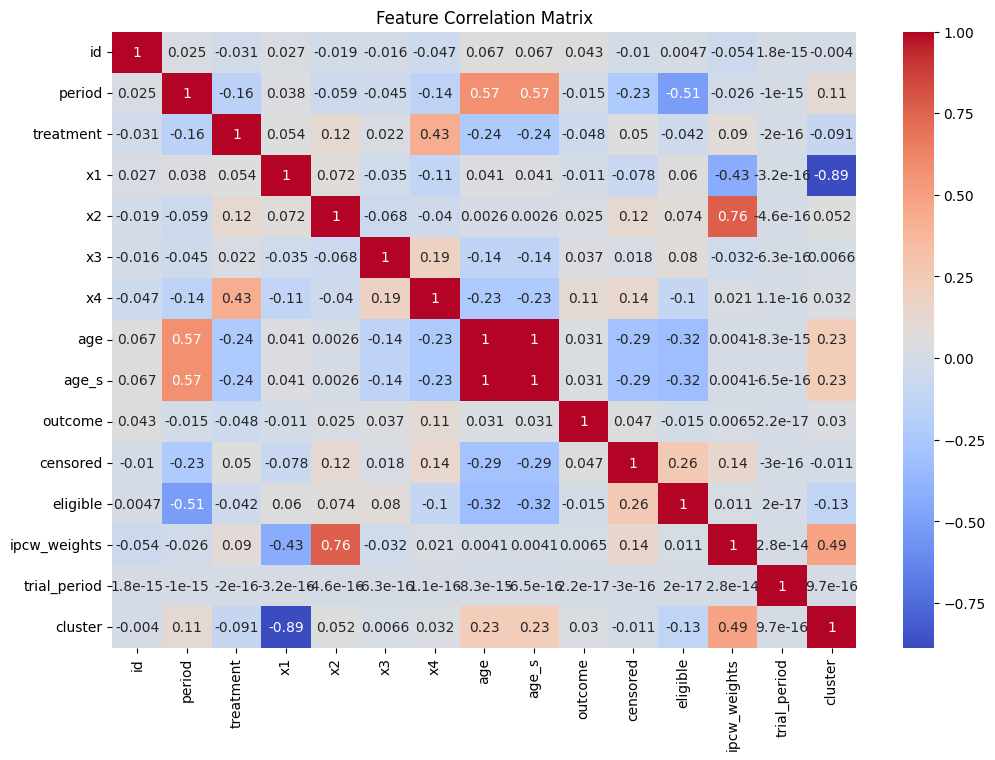

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = expanded_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
# Drop highly correlated columns
drop_cols = ["age_s","id"]
cox_data_filtered = expanded_data.drop(columns=drop_cols)

# Re-run the Cox model
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(cox_data_filtered, duration_col="period", event_col="outcome")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7250 total observations, 7140 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 7250
number of events observed = 110
   partial log-likelihood = -738.44
         time fit was run = 2025-03-09 08:13:15 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
treatment     -2.57      0.08      0.29           -3.13           -2.00                0.04                0.14
x1            -2.78      0.06      1.09           -4.91           -0.65                0.01                0.52
x2             3.62     37.35      0.67            2.31            4.93               10.08              138.44
x3            -0.21      0.81      0.23           -0.67            0.24                0.51                1.28
x4             1.83      6.22      0.14            1.54            2.11                4.69                8.26
age           -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
censored       1.63      5.11      0.33            0.98            2.28                2.68                9.74
eligible       1.80      6.08      0.39            1.04            2.57                2.83               13.06
ipcw_weights -73.31      0.00     14.90         -102.51          -44.10                0.00                0.00
trial_period  -0.00      1.00      0.03           -0.07            0.07                0.94                1.07
cluster        0.97      2.65      0.36            0.27            1.68                1.32                5.34

              cmp to     z      p  -log2(p)
covariate                                  
treatment       0.00 -8.87 <0.005     60.27
x1              0.00 -2.56   0.01      6.59
x2              0.00  5.42 <0.005     23.97
x3              0.00 -0.91   0.36      1.47
x4              0.00 12.64 <0.005    119.26
age             0.00 -0.91   0.36      1.46
censored        0.00  4.95 <0.005     20.33
eligible        0.00  4.62 <0.005     18.00
ipcw_weights    0.00 -4.92 <0.005     20.14
trial_period    0.00 -0.00   1.00      0.00
cluster         0.00  2.73   0.01      7.29
---
Concordance = 0.91
Partial AIC = 1498.87
log-likelihood ratio test = 315.51 on 11 df
-log2(p) of ll-ratio test = 200.40

## **Kaplan-Meier Survival Analysis for Clusters**


We compare survival probabilities between the different clusters by using the Kaplan-Meier model to see the differences in survival probability over time.

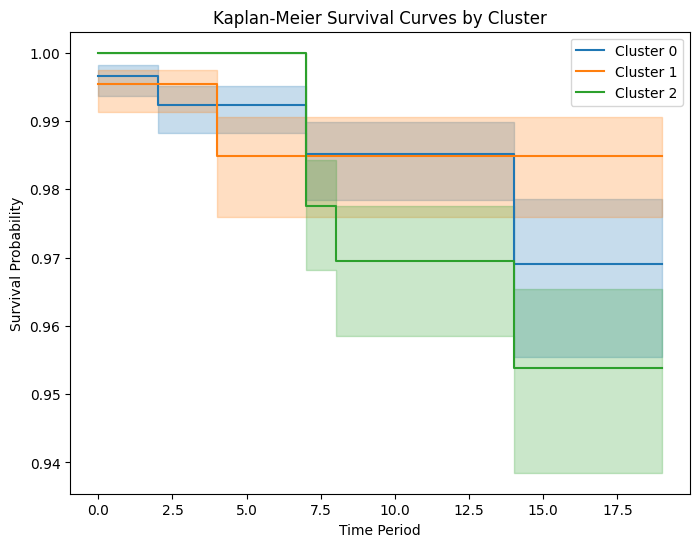

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Create a figure
plt.figure(figsize=(8, 6))

# Loop through each unique cluster and plot its survival curve
for cluster in expanded_data["cluster"].unique():
    cluster_data = expanded_data[expanded_data["cluster"] == cluster]

    # Fit Kaplan-Meier model for this cluster
    kmf.fit(durations=cluster_data["period"],
            event_observed=cluster_data["outcome"],
            label=f"Cluster {cluster}")

    # Plot the survival curve
    kmf.plot_survival_function()

# Format the plot
plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time Period")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()



## Insights from Hierarchical Clustering and Survival Analysis

### **1. Hierarchical Clustering Findings**
- Agglomerative clustering (Ward’s Method) was applied using **x1, x2, and age** as features.
- The dendrogram determined the optimal number of clusters, resulting in **three clusters**:
  - **Cluster 0**: 294 observations
  - **Cluster 1**: 215 observations
  - **Cluster 2**: 216 observations
- These clusters represent distinct groups with potentially different treatment responses or risk profiles.

### **2. Survival Analysis with Cox Proportional Hazards Model**
- The model identified significant predictors of survival:
  - **Treatment (-2.57, HR = 0.08)**: Strongly reduces hazard, indicating a protective effect.
  - **x1 (-2.78, HR = 0.06)**: Negatively correlated with hazard, suggesting a protective role.
  - **x2 (3.62, HR = 37.35)**: Increases hazard significantly, indicating a high-risk factor.
  - **x4 (1.83, HR = 6.22)**: Associated with higher hazard.
  - **Cluster (0.97, HR = 2.65)**: Being in a specific cluster affects hazard.
- The **concordance score (0.91)** suggests strong predictive accuracy.

### **3. Kaplan-Meier Survival Analysis**
- The survival curves for the three clusters showed distinct trends.
- Certain clusters exhibited a **steeper decline**, indicating worse survival, while others had a **gradual decline**, suggesting better survival outcomes.
- This confirms that the clustering approach successfully captured meaningful differences in survival probabilities.

### **4. Key Takeaways**
- **Risk stratification:** Cluster **2** may represent **higher-risk** patients, while **Cluster 0** may have better survival outcomes.
- **Treatment effectiveness:** The strong negative coefficient for treatment suggests a significant benefit in reducing hazard.
- **Further analysis:** Additional validation, such as silhouette scores or interaction effects, may refine the findings.
